In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

#Read Input Image

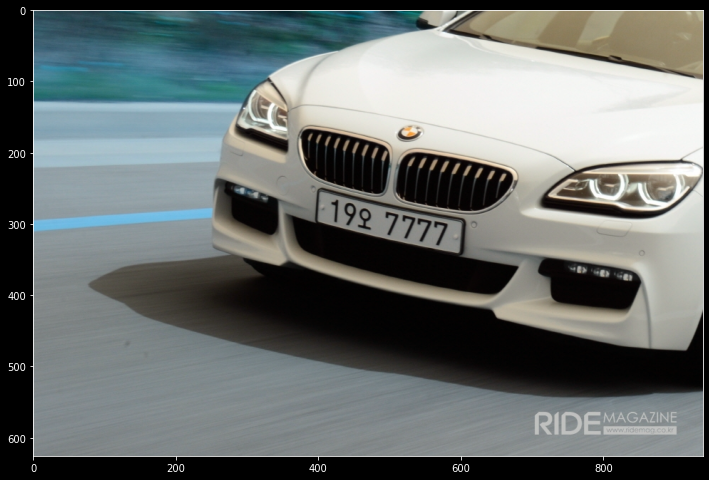

In [39]:
img_ori = cv2.imread('1.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

#Convert Image to Grayscale


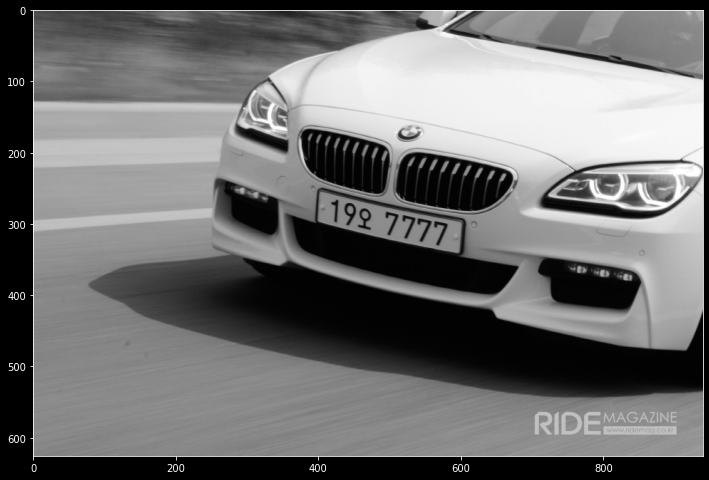

In [40]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
# hsv에서 v채널만 사용하는 사람도 있음

gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

#Maximize Contrast (Optional)

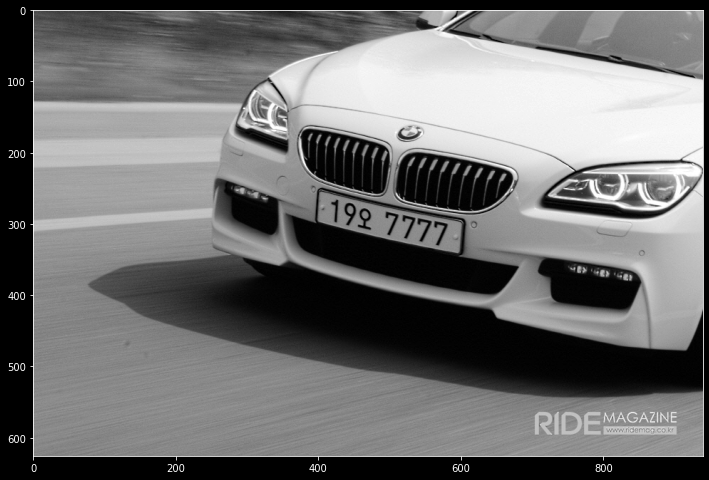

In [41]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

In [ ]:
'''
cv2.getStructuringElement(shape, ksize, [anchor]) -> retval
* shape : 구조화 요소 커널 모양
cv2.MORPH_CROSS : 십자가형
cv2.MORPH_ELLIPSE : 타원형
cv2.MORPH_RECT : 직사각형
cv::Morphshape 참고...

ksize : 구조화 요소 커널의 크기
anchor : 구조화 요서 커널의 기준점. default값은 (-1,-1)이고, 이건 cross모양에만 영향을 줌
cross일때 이 기준점이 있는 열과 행의 값만 1로 채워짐


'''

#Adaptive Thresholding

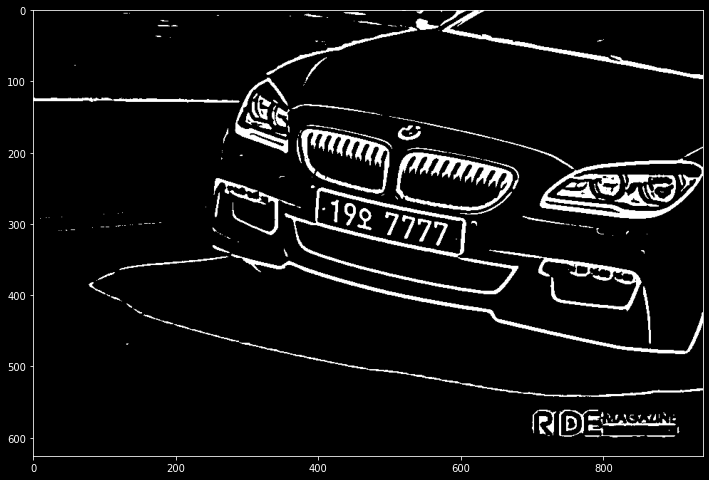

In [15]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
# 노이즈를 주는 것

# 이미지의 threshold를 지정해주고, 그 값을 기준으로 크면 255, 작으면 0으로 바로 바꾸기
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# 가우시안 하고 한 거랑 안하고 한 거 비교

In [18]:
img_thresh_only = cv2.adaptiveThreshold(
    gray, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

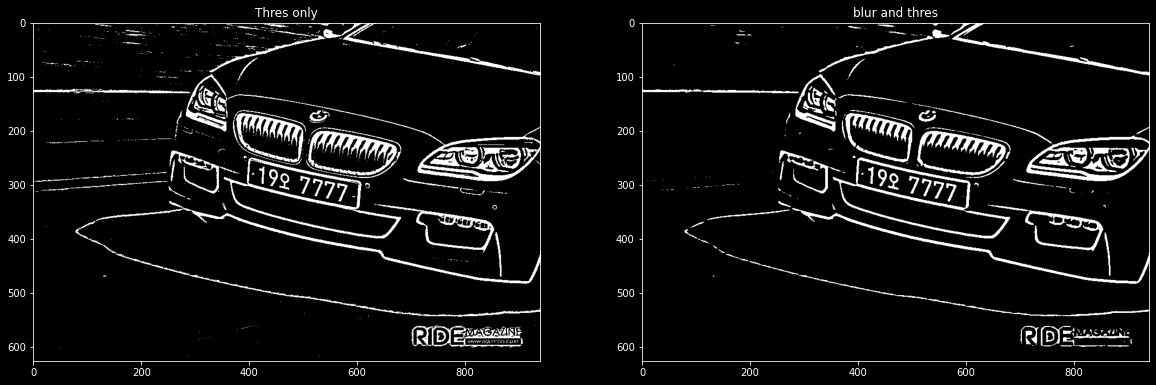

In [20]:
plt.figure(figsize = (20, 20))
plt.subplot(1,2,1)
plt.title('Thres only')
plt.imshow(img_thresh_only, cmap = 'gray')

plt.subplot(1,2,2)
plt.title('blur and thres')
plt.imshow(img_thresh, cmap = 'gray')

# Find Contours
윤곽선 찾기


In [ ]:
# not enough values to unpack (expected 3, got 2) 오류건 ->  _, contours의  _, 삭제후 pytesseract만 설치하면 되는듯 합니다.

# 밑에서 오류 떴었음

In [ ]:
#_, contours, _ = cv2.findContours(
# img , contours, hierarchy = cv2.find~~~

contours, _ = cv2.findContours(
    img_thresh,  # 이 이미지에서 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

# 제일 위에서 받아온 인수들
temp_result = np.zeros((height, width, channel), dtype=np.uint8)


cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255)) # contourIdx = -1 -> 모든 윤곽선을 그리겠다는 뜻

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

In [ ]:
'''
cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

첫번째 -> countour 찾기를 할 소스 이미지. thresholding을 통해 변환된 바이너리 이미지어야 함

두번째 -> contour 추출 모드
- cv2.RETR_TREE : 2번째 리턴값인 hierarchy의 값에 영향
- cv2.RETR_EXTERNAL : 이미지 가장 바깥쪽 경계선만
- cv2.RETR_LIST : 경계선의 계층 구조 상관관계 고려 없이, contour 추출
- cv2.RETR_CCOMP
- cv2.RETR_
- cv2.RETR_

세번째 -> contour 근사 방법
- cv2.CHAIN_APPROX_NONE : contour를 구성하는 모든 점을 저장
- cv2.CHAIN_APPROX_SIMPLE : 수평 수직 대각선 방향의 점은 모두 버리고, 끝 점만 남김. ex) 삼각형의 경우 꼭지점만 나두고 선 다 지움
- cv2.CHAIN_APPROX_TC89_1 :Teh-Chine 연결 근사 알고리즘 적용




'''

# Prepare Data

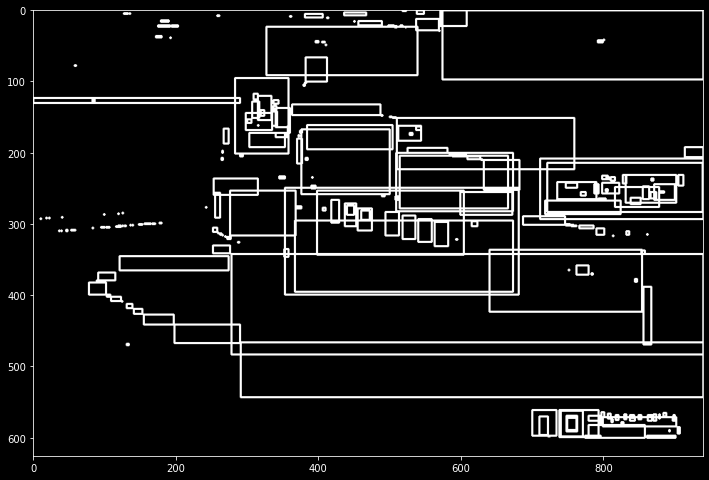

In [32]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

# contours는 리스트 형태로 들어가 있음
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

#Select Candidates by Char Size


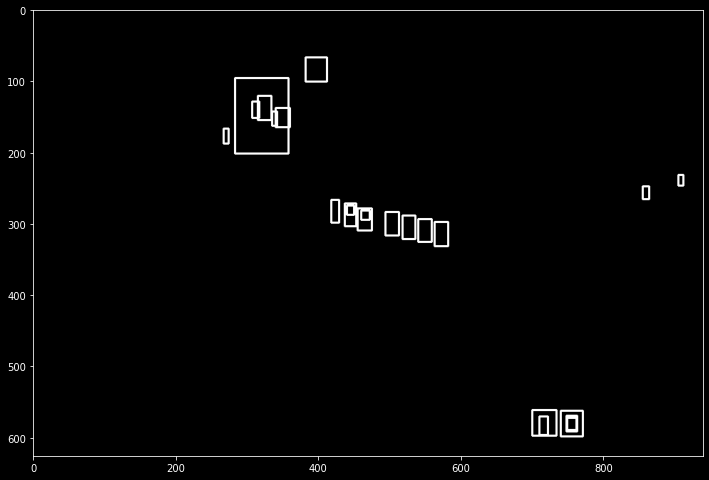

In [33]:
# 번호판의 글자 처럼 생긴 애들만 뽑아 내기

# 번호판의 숫자 모양에 대한 .. 
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 가로 대비 세로의 비율

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h'] # 넓이
    ratio = d['w'] / d['h'] # 가로 대비 세로의 비율
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Arrangement of Contours

번호판의 배열 같은 것만 골라 내기

In [34]:
# contour와 contour 사이의 거리 제한
# 즉, 첫번쨰 contour와 두번째 contour의 중점 사이의 거리가, 첫번째 contour의 대각선 길이 5배 안에 있어야 한다. 
MAX_DIAG_MULTIPLYER = 5 # 5

#  첫번쨰 contour와 두번째 contour의 중점을 연결해서 (그걸 빗변으로) 직각 삼각형을 그렸을 때, 첫번째 contour 중점 기준 세타(각도)의 최대 값
MAX_ANGLE_DIFF = 12.0 # 12.0

# 첫번쨰 contour와 두번째 contour의 면적의 차이
MAX_AREA_DIFF = 0.5 # 0.5

# 첫번쨰 contour와 두번째 contour의 넓이 차이
MAX_WIDTH_DIFF = 0.8
# 첫번쨰 contour와 두번째 contour의 높이 차이
MAX_HEIGHT_DIFF = 0.2

# 위의 과정을 통해 그룹 후보군을 정했을 때, n개 미만이면 번호판이 아니니까 후보에서 통째로 제외
MIN_N_MATCHED = 3 # 3

# 재귀함수식으로 번호판여부를 확인하기 때문에 함수로 지정
def find_chars(contour_list):

    # 최종 후보군
    matched_result_idx = []
    
    # 어떤 contour d1과 그것을 제외한 d2를 비교하기 위해 이중 for문을 돌게 됨
    for d1 in contour_list:
        
        # 임시 후보군
        matched_contours_idx = []
    
        for d2 in contour_list:
            # 같은 contour는 제외
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            # 빗변 길이 구하기
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            
            # 다른 비율들
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # d1 기준으로 했기 때문에 d2,d3 해주고 마지막에 d1 넣어주기
        # append this contour
        matched_contours_idx.append(d1['idx'])


        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)


        # 최종 후보군이 아닌 애들도 한번 다시 비교해주기
        unmatched_contour_idx = []
         
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx) # possible 리스트에서 idx에 해당하는 원소 뽑아내기
        
        # recursive (재귀)
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

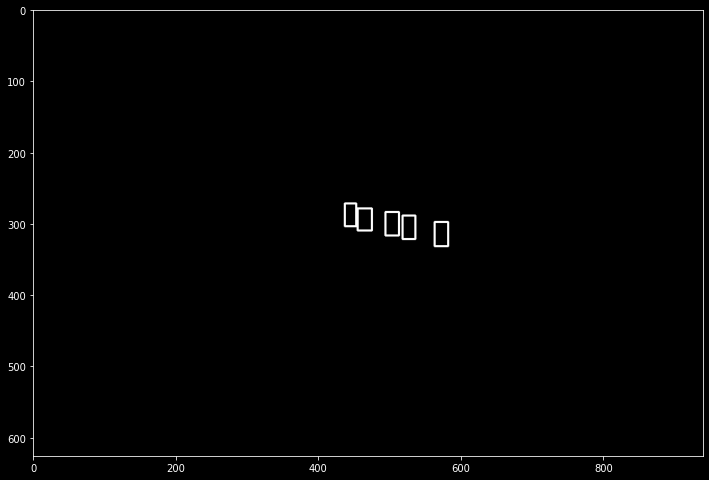

In [37]:
result_idx = find_chars(possible_contours)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Plate Images

바른 상태로 번호판 돌리기

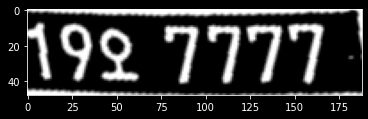

In [38]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0

    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']

    # 빗변의 길이
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    # 라디안 값을 도 로 바꿔줌 (1라디안, 18도 이런 명칭으로)
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus)) 
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    # 똑바로 돌리기
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    # 원하는 부분만 자르기
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# Another Thresholding to Find Chars

In [ ]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)

    # 오수 알고리즘을 통해 thresholding
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above) 한번 더 contour를 보고 확실한지 확인
    _, contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    # 글씨를 더 잘 보이게 하기 위해 전처리

    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # 패딩 줘서 더 잘 인식할 수 있게 도와주기
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

# tesseract 기준인데 안해놔서 뺌

    # chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0') # 몇 번이냐에 따라서 달라짐. 글자를 한번 배워야함. 깃허브 가서 봐야함. 강의 참조
    
    # result_chars = ''
    # has_digit = False
    # for c in chars:
    #     if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
    #         if c.isdigit():
    #             has_digit = True
    #         result_chars += c
    
    # print(result_chars)
    # plate_chars.append(result_chars)

    # if has_digit and len(result_chars) > longest_text:
    #     longest_idx = i

    # plt.subplot(len(plate_imgs), 1, i+1)
    # plt.imshow(img_result, cmap='gray')

# Result


In [ ]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)